# Inaccurate testing

In this notebook, we relax the accurate testing assumption by accounting for the possibility of false positives and negatives in antigen testing. To do this, we incorporate two additional parameters into our model:

- The true positive rate (antigen test sensitivity)
- The true negative rate (antigen test specificity)

These are parameters are estimated within the model, and are pinned down by informative priors calibrated with data from the [Joint PHE Porton Down & University of Oxford SARS-CoV-2 test development and validation cell](https://www.ox.ac.uk/sites/files/oxford/media_wysiwyg/UK%20evaluation_PHE%20Porton%20Down%20%20University%20of%20Oxford_final.pdf). 

In [1]:
import time
import arviz
import numpy as np
import pandas as pd
import stan
import nest_asyncio
nest_asyncio.apply()

In [2]:
# Parameters
P = 10
N = 3*(10 ** 4)
SEED = 1729

In [3]:
# Ground truth
np.random.seed(SEED)
true_transmission_rate = np.random.beta(2, 10, P)
true_occurrence_rate = np.random.beta(2, 10, P)
base_rate = np.random.beta(2, 10, 1)

test_sensitivity = np.random.beta(4, 3, 1)  # True positive rate
test_specificity = np.random.beta(50, 2, 1)  # True negative rate
true_lambda = np.array([test_sensitivity, test_specificity])

In [4]:
# Simulate data
data = {}
for p in range(P):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N)
    transmission = occurrence * np.random.binomial(1, true_transmission_rate[p], N)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission

data['T0'] = np.random.binomial(1, base_rate, N)
X = pd.DataFrame(data)
z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
y = (z > 0).astype(int)

# Introducing false positives and negatives
y = y*np.random.binomial(1, true_lambda[0], N) + (1-y)*np.random.binomial(1, (1-true_lambda[1]), N)

X = X.loc[:, X.columns.str.startswith('O')]
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   O1      30000 non-null  int64
 1   O2      30000 non-null  int64
 2   O3      30000 non-null  int64
 3   O4      30000 non-null  int64
 4   O5      30000 non-null  int64
 5   O6      30000 non-null  int64
 6   O7      30000 non-null  int64
 7   O8      30000 non-null  int64
 8   O9      30000 non-null  int64
 9   O10     30000 non-null  int64
dtypes: int64(10)
memory usage: 2.3 MB


In [16]:
# Set antigen test mean and std. error for TP and TN rates (for strong priors)

# True positive
mean_tp = 0.73000
se_tp = 0.04133

# True negative
mean_tn = 0.99680
se_tn = 0.00066

mean_rates = [mean_tp, mean_tn]
se_rates = [se_tp, se_tn]
alphas = []
betas = []
for i in range(1):
    alphas[i] = (((1-mean_rates[i])/se_rates[i]**2)-(1/mean_rates[i]))*(mean_rates[i]**2)
    betas[i] = alphas[i]*((1/mean_rates[i])-1)
print(alphas)
print(betas)

IndexError: list assignment index out of range

In [5]:
# Create model
model_code = """
data {
  int<lower=0> N;                            // number of test observations
  int<lower=0> P;                            // number of places
  int<lower=0, upper=1> X[N,P];              // activity occurrences of tested individuals
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
  real<lower=0, upper=1> mean_lambda[2];     // mean TP and TN test rates (for strong priors on tests)
  real<lower=0> se_lambda[2];                // standard error of test rates (for strong priors on tests)
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> rho;                // underlying risk
  real<lower=0, upper=1> lambda[2];          // True positive and true negative rates of tests [TP,TN]
}
model {
  // Precomputation
  real log1m_theta[P];
  real log1m_rho;
  real log_lambda[2];
  real log1m_lambda[2];
  real a_lambda[2];
  real b_lambda[2];
  
  for (p in 1:P) {
    log1m_theta[p] = log1m(theta[p]);
  }
  for(i in 1:2){
    log_lambda[i] = log(lambda[i]);
    log1m_lambda[i] = log1m(lambda[i]);
    
    a_lambda[i] = (((1-mean_lambda[i])/se_lambda[i]^2)-(1/mean_lambda[i]))*(mean_lambda[i]^2);
    b_lambda[i] = a_lambda[i]*((1/mean_lambda[i])-1);
  }
  
  log1m_rho = log1m(rho);
  
  // Priors
  theta ~ uniform(0, 1);
  rho ~ uniform(0, 1);
  lambda[1] ~ beta(a_lambda[1], b_lambda[1]);
  lambda[2] ~ beta(a_lambda[2], b_lambda[2]);

  // Likelihood
  for (n in 1:N) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        s += log1m_theta[p];
      }
    }
    s += log1m_rho;
    
    if (y[n] == 1) {
      target += log_sum_exp((log1m_exp(s) + log_lambda[1]), (s + log1m_lambda[2]));
    } 
    else {
      target += log_sum_exp((s + log_lambda[2]), (log1m_exp(s) + log1m_lambda[1]));
    }
  }
}
""" 

In [7]:
# Build model
model_data = {'N': N, 'P': P, 
              'X': X.to_numpy(), 'y': y.to_numpy(),
              'mean_lambda':mean_rates, 'se_lambda':se_rates}
posterior = stan.build(model_code, data=model_data, random_seed=1)

Building... This may take some time.
Messages from stanc:
  The parameter lambda has no priors.
Done.


In [ ]:
# Set NUTS parameters
nuts_samples = 1000
nuts_burnin = 500
nuts_chains = 16

# Posterior sampling
start = time.time()
fit = posterior.sample(num_samples=nuts_samples, num_warmup=nuts_burnin, num_chains=nuts_chains)
print(f"{time.time() - start:.02f} seconds elapsed")

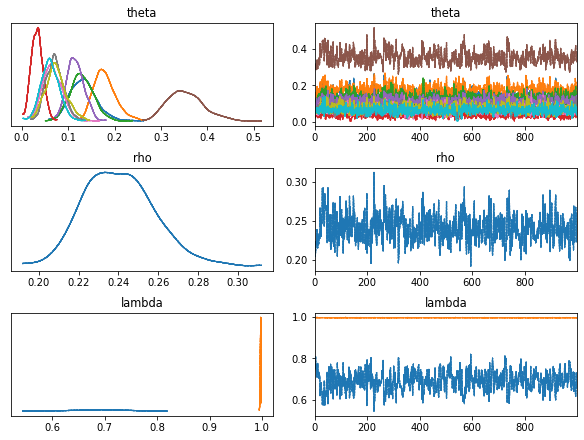

In [9]:
# Evaluate fit with test and trace resample
arviz.plot_trace(fit, figsize=(8, 6));

In [10]:
fit = fit.to_frame()
print("Inference on fitted model:")
fit.describe().T

Inference on fitted model:


,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
lp__,16000.0,-17001.745265,2.653318e+00,-17017.091299,-17003.304464,-17001.522090,-16999.825519,-16995.893198
accept_stat__,16000.0,0.921627,1.057700e-01,0.365266,0.895409,0.966956,0.991930,1.000000
stepsize__,16000.0,0.132839,3.858146e-14,0.132839,0.132839,0.132839,0.132839,0.132839
treedepth__,16000.0,4.797000,4.096358e-01,3.000000,5.000000,5.000000,5.000000,6.000000
n_leapfrog__,16000.0,30.176000,8.550883e+00,7.000000,31.000000,31.000000,31.000000,63.000000
divergent__,16000.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
energy__,16000.0,17008.272240,3.698092e+00,16999.479483,17005.727317,17007.967964,17010.609952,17022.448299
theta.1,16000.0,0.133333,2.910036e-02,0.057876,0.112547,0.132362,0.149624,0.262661
theta.2,16000.0,0.179277,2.415574e-02,0.120556,0.162304,0.176655,0.192849,0.267099


In [11]:
print('Ground truth:')
print('Setting-specific transmission rates: ', true_transmission_rate)
print('Base rate: ', base_rate)
print('True positive and negative rates: ', true_lambda)

Ground truth:
Setting-specific transmission rates:  [0.11229016 0.21544007 0.1340044  0.03496042 0.14024028 0.38996209
 0.06151853 0.09666885 0.08617048 0.05264691]
Base rate:  [0.20607471]
True positive and negative rates:  [[0.63441615]
 [0.95344544]]
